In [ ]:
#!pip install python-chess==0.31.2
#%ls !unzip src.zip

In [ ]:
import chess
import sys
import torch
import random
from transformers import GPT2LMHeadModel, AutoModel
sys.path.append("src")
from data_utils.chess_tokenizer import ChessTokenizer
import chess.pgn as pgn
import io
from datasets import load_dataset

# Initialize the Model and the Tokenizer

vocab_path = "vocab.txt"
tokenizer = ChessTokenizer(vocab_path)
model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

def get_legal_moves(board):
    legal_moves = set()
    for move in board.legal_moves:
        uci_move = board.uci(move)
        legal_moves.add(uci_move)
    return legal_moves

ds = load_dataset("adamkarvonen/chess_sae_individual_games_filtered")

def chop_game_at_random_point(pgn):
    # Split the PGN string into individual moves
    moves = pgn.split()
    
    # Filter out the move numbers (e.g., "1.", "2.", etc.)
    game_moves = [move for move in moves if not move[0].isdigit()]
    
    # Determine the total number of moves
    total_moves = len(game_moves)
    
    # Ensure we have an even number of moves for simplicity
    if total_moves % 2 != 0:
        total_moves -= 1
    
    # Randomly choose a point to chop, ensuring 50/50 white/black split
    random_index = random.randint(7, total_moves - 1)
    
    # Determine if the random point should be a white or black move
    if random_index % 2 == 0:
        chopped_game = ' '.join(moves[:random_index + 1])
    else:
        chopped_game = ' '.join(moves[:random_index + 2])
    
    return chopped_game

# probing to see if the game provides legal moves given the starting square

def predict_move1(move):

    game_prefix = [tokenizer.bos_token_id]
    game_prefix_str = ""

    game_prefix.extend(tokenizer.encode(move, add_special_tokens=False, get_move_end_positions=False))
    game_prefix_str += move + " "

    greedy_game_prefix = list(game_prefix)
    prefix_tens = torch.tensor([greedy_game_prefix])
    pred_move = ""

    #range was 3 in orig.
    for idx in range(3):
        logits = model(prefix_tens)[0]
        
        # logits is a 3-dimensional tensor with the shape [batch_size, sequence_length, vocab_size].
        # --> Extracting the logits for the last token.
        last_token_logit = logits[0, -1, :]

        token_idx = torch.argmax(last_token_logit).item()
        
        current_token = tokenizer.decode_token(token_idx)
        pred_move += current_token

        if idx == 0 and current_token == tokenizer.eos_token:
            break

        greedy_game_prefix += [token_idx]
        prefix_tens = torch.tensor([greedy_game_prefix])

    if len(pred_move) == 6:
        pred_move = pred_move[:4]

    legal_moves = get_legal_moves(board)
    if pred_move not in legal_moves:
        print("ILLEGAL MOVE")
        print(f"Legal moves: {legal_moves}")

    print(f"LM plays: {pred_move}")

def probing_legal_moves1(move0):
    legal_moves = get_legal_moves(board)
    illegal_count = 0
    for leg_move in legal_moves:

        initial_square = leg_move[:2]
        move = move0 + " " + initial_square

        game_prefix = [tokenizer.bos_token_id]
        game_prefix_str = ""

        game_prefix.extend(tokenizer.encode(move, add_special_tokens=False, get_move_end_positions=False))
        game_prefix_str += move + " "

        greedy_game_prefix = list(game_prefix)
        prefix_tens = torch.tensor([greedy_game_prefix])
        pred_move = ""

        for idx in range(1):
            logits = model(prefix_tens)[0]
        
            # logits is a 3-dimensional tensor with the shape [batch_size, sequence_length, vocab_size].
            # --> Extracting the logits for the last token.
            last_token_logit = logits[0, -1, :]

            token_idx = torch.argmax(last_token_logit).item()
            
            current_token = tokenizer.decode_token(token_idx)
            pred_move += current_token

            if idx == 0 and current_token == tokenizer.eos_token:
                break

            greedy_game_prefix += [token_idx]
            prefix_tens = torch.tensor([greedy_game_prefix])

            if len(pred_move) == 6:
                pred_move = pred_move[:4]


            pred_move = initial_square + pred_move
            if pred_move not in legal_moves:
            #print("ILLEGAL MOVE")
            #print(f"Legal moves: {legal_moves}")
                illegal_count += 1

            #print(f"LM plays: {pred_move}")

    print(f"Ratio legal/total: {len(legal_moves)-illegal_count} / {len(legal_moves)}")


g = random.randint(0, 90000)
a = ds['train']['text'][g][1:]
b = chop_game_at_random_point(a)

b1 = io.StringIO(b)
game = pgn.read_game(b1)
board = game.board()

move_list = []
for move in game.mainline_moves():
    move_list.append(board.uci(move))
    board.push(move)
b1 = (" ".join(move_list))

print(b)
print(b1)

move = b1
predict_move1(move)
probing_legal_moves1(move)


In [ ]:
def probe_with_masked_move(move_sequence):
    moves = move_sequence.split()
    if len(moves) < 3:
        print("The move sequence is too short to mask a move in the middle.")
        return

    # Choose a random move to mask (excluding first and last moves)
    mask_index = random.randint(1, len(moves) - 2)
    masked_move = moves[mask_index]
    moves[mask_index] = "[MASK]"

    # Create the input sequence with the masked move
    input_sequence = " ".join(moves[:mask_index+1])

    game_prefix = [tokenizer.bos_token_id]
    game_prefix.extend(tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False))

    greedy_game_prefix = list(game_prefix)
    prefix_tens = torch.tensor([greedy_game_prefix])
    pred_move = ""

    for idx in range(4):  # Predict 4 tokens to get a full move
        logits = model(prefix_tens)[0]
        last_token_logit = logits[0, -1, :]
        token_idx = torch.argmax(last_token_logit).item()
        current_token = tokenizer.decode_token(token_idx)
        pred_move += current_token

        if current_token == tokenizer.eos_token:
            break

        greedy_game_prefix += [token_idx]
        prefix_tens = torch.tensor([greedy_game_prefix])

    if len(pred_move) >= 4:
        pred_move = pred_move[:4]

    print(f"Original move sequence: {move_sequence}")
    print(f"Masked move sequence: {' '.join(moves)}")
    print(f"Masked move: {masked_move}")
    print(f"Predicted move: {pred_move}")
    print(f"Correct prediction: {pred_move == masked_move}")

    # Reconstruct the board state just before the masked move
    board = chess.Board()
    for move in moves[:mask_index]:
        board.push_uci(move)

    legal_moves = get_legal_moves(board)
    print(f"Predicted move is legal: {pred_move in legal_moves}")
    print(f"Legal moves: {legal_moves}")



In [ ]:
# Example usage
g = random.randint(0, 90000)
a = ds['train']['text'][g][1:]
b = chop_game_at_random_point(a)

b1 = io.StringIO(b)
game = pgn.read_game(b1)
board = game.board()

move_list = []
for move in game.mainline_moves():
    move_list.append(board.uci(move))
    board.push(move)
b1 = " ".join(move_list)

print("Original game:")
print(b)
print("UCI move sequence:")
print(b1)

# Call the new function
probe_with_masked_move(b1)

In [ ]:
import chess
import sys
import torch
import random
from transformers import GPT2LMHeadModel, AutoModel
sys.path.append("src")
from data_utils.chess_tokenizer import ChessTokenizer
import chess.pgn as pgn
import io
from datasets import load_dataset

# Initialize the Model and the Tokenizer
vocab_path = "vocab.txt"
tokenizer = ChessTokenizer(vocab_path)
model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

def get_legal_moves(board):
    legal_moves = set()
    for move in board.legal_moves:
        uci_move = board.uci(move)
        legal_moves.add(uci_move)
    return legal_moves

ds = load_dataset("adamkarvonen/chess_sae_individual_games_filtered")

def predict_move(input_sequence):
    game_prefix = [tokenizer.bos_token_id]
    game_prefix.extend(tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False))

    greedy_game_prefix = list(game_prefix)
    prefix_tens = torch.tensor([greedy_game_prefix])
    pred_move = ""

    for idx in range(4):  # Predict 4 tokens to get a full move
        logits = model(prefix_tens)[0]
        last_token_logit = logits[0, -1, :]
        token_idx = torch.argmax(last_token_logit).item()
        current_token = tokenizer.decode_token(token_idx)
        pred_move += current_token

        if current_token == tokenizer.eos_token:
            break

        greedy_game_prefix += [token_idx]
        prefix_tens = torch.tensor([greedy_game_prefix])

    if len(pred_move) >= 4:
        pred_move = pred_move[:4]
    
    return pred_move

def probe_with_masked_move(move_sequence):
    moves = move_sequence.split()
    if len(moves) < 3:
        print("The move sequence is too short to mask a move in the middle.")
        return

    # Choose a random move to mask (excluding first and last moves)
    mask_index = random.randint(1, len(moves) - 2)
    masked_move = moves[mask_index]
    
    # Predict using only past moves
    past_input_sequence = " ".join(moves[:mask_index])
    past_pred_move = predict_move(past_input_sequence)

    # Predict using both past and future moves
    future_input_sequence = " ".join(moves[:mask_index] + moves[mask_index+1:])
    future_pred_move = predict_move(future_input_sequence)

    print(f"Original move sequence: {move_sequence}")
    print(f"Move sequence with masked move: {' '.join(moves[:mask_index] + ['[MASKED]'] + moves[mask_index+1:])}")
    print(f"Masked move: {masked_move}")
    print(f"\nPrediction using only past moves:")
    print(f"Predicted move: {past_pred_move}")
    print(f"Correct prediction: {past_pred_move == masked_move}")
    print(f"\nPrediction using both past and future moves:")
    print(f"Predicted move: {future_pred_move}")
    print(f"Correct prediction: {future_pred_move == masked_move}")

    # Reconstruct the board state just before the masked move
    board = chess.Board()
    for move in moves[:mask_index]:
        board.push_uci(move)

    legal_moves = get_legal_moves(board)
    print(f"\nPredicted move (past only) is legal: {past_pred_move in legal_moves}")
    print(f"Predicted move (with future) is legal: {future_pred_move in legal_moves}")
    print(f"Legal moves: {legal_moves}")

# Example usage
g = random.randint(0, 90000)
a = ds['train']['text'][g][1:]
b = chop_game_at_random_point(a)

b1 = io.StringIO(b)
game = pgn.read_game(b1)
board = game.board()

move_list = []
for move in game.mainline_moves():
    move_list.append(board.uci(move))
    board.push(move)
b1 = " ".join(move_list)

print("Original game:")
print(b)
print("UCI move sequence:")
print(b1)

# Call the new function to probe with the same masked move for both scenarios
probe_with_masked_move(b1)

In [ ]:
import chess
import sys
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2LMHeadModel, AutoModel
sys.path.append("src")
from data_utils.chess_tokenizer import ChessTokenizer
import chess.pgn as pgn
import io
from datasets import load_dataset
import numpy as np
from scipy.spatial.distance import cosine

# Initialize the Model and the Tokenizer
vocab_path = "vocab.txt"
tokenizer = ChessTokenizer(vocab_path)
model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

ds = load_dataset("adamkarvonen/chess_sae_individual_games_filtered")

def get_model_output(input_sequence):
    # Encode the input sequence
    encoded = tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)
    # Convert to tensor and add batch dimension
    inputs = torch.tensor([encoded]).long()
    with torch.no_grad():
        outputs = model(inputs, output_attentions=True, output_hidden_states=True)
    return outputs

def visualize_attention(input_sequence, layer=-1, head=0):
    outputs = get_model_output(input_sequence)
    attention = outputs.attentions[layer][0, head].cpu().numpy()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention, cmap="YlOrRd")
    plt.title(f"Attention weights for layer {layer}, head {head}")
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    plt.show()

def compute_move_similarity(move1, move2):
    outputs1 = get_model_output(move1)
    outputs2 = get_model_output(move2)
    
    # Use the last hidden state as the representation
    repr1 = outputs1.last_hidden_state[0, -1].cpu().numpy()
    repr2 = outputs2.last_hidden_state[0, -1].cpu().numpy()
    
    similarity = 1 - cosine(repr1, repr2)
    return similarity

def probe_attention_and_similarity(move_sequence):
    moves = move_sequence.split()
    if len(moves) < 3:
        print("The move sequence is too short for meaningful analysis.")
        return

    # Visualize attention for the whole sequence
    print("Visualizing attention for the entire move sequence:")
    visualize_attention(move_sequence)

    # Compute similarity between consecutive moves
    print("\nComputing similarity between consecutive moves:")
    for i in range(len(moves) - 1):
        sim = compute_move_similarity(moves[i], moves[i+1])
        print(f"Similarity between '{moves[i]}' and '{moves[i+1]}': {sim:.4f}")

    # Compute similarity between the first and last move
    first_last_sim = compute_move_similarity(moves[0], moves[-1])
    print(f"\nSimilarity between first move '{moves[0]}' and last move '{moves[-1]}': {first_last_sim:.4f}")

# Example usage
g = random.randint(0, 90000)
a = ds['train']['text'][g][1:]
b = chop_game_at_random_point(a)

b1 = io.StringIO(b)
game = pgn.read_game(b1)
board = game.board()

move_list = []
for move in game.mainline_moves():
    move_list.append(board.uci(move))
    board.push(move)
b1 = " ".join(move_list)

print("Original game:")
print(b)
print("UCI move sequence:")
print(b1)

# Perform probing
probe_attention_and_similarity(b1)

In [ ]:
import chess
import sys
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2LMHeadModel, AutoModel
sys.path.append("src")
from data_utils.chess_tokenizer import ChessTokenizer
import chess.pgn as pgn
import io
from datasets import load_dataset
import numpy as np
from scipy.spatial.distance import cosine

# Initialize the Model and the Tokenizer
vocab_path = "vocab.txt"
tokenizer = ChessTokenizer(vocab_path)
model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

ds = load_dataset("adamkarvonen/chess_sae_individual_games_filtered")

def get_model_output(input_sequence):
    # Encode the input sequence
    encoded = tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)
    # Convert to tensor and add batch dimension
    inputs = torch.tensor([encoded]).long()
    with torch.no_grad():
        outputs = model(inputs, output_attentions=True, output_hidden_states=True)
    return outputs

def visualize_attention(input_sequence, layer=-1, head=0):
    outputs = get_model_output(input_sequence)
    attention = outputs.attentions[layer][0, head].cpu().numpy()
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(attention, cmap="YlOrRd")
    plt.title(f"Attention weights for layer {layer}, head {head}")
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    plt.show()

def compute_move_similarity(move1, move2):
    outputs1 = get_model_output(move1)
    outputs2 = get_model_output(move2)
    
    # Use the last hidden state as the representation
    repr1 = outputs1.hidden_states[-1][0, -1].cpu().numpy()
    repr2 = outputs2.hidden_states[-1][0, -1].cpu().numpy()
    
    similarity = 1 - cosine(repr1, repr2)
    return similarity

def probe_attention_and_similarity(move_sequence):
    moves = move_sequence.split()
    if len(moves) < 3:
        print("The move sequence is too short for meaningful analysis.")
        return

    # Visualize attention for the whole sequence
    print("Visualizing attention for the entire move sequence:")
    visualize_attention(move_sequence)
    visualize_attention(move_sequence, -2)
    visualize_attention(move_sequence, -3)
    visualize_attention(move_sequence, -4)
    visualize_attention(move_sequence, -5)
    visualize_attention(move_sequence, -6)

    # Compute similarity between consecutive moves
    print("\nComputing similarity between consecutive moves:")
    for i in range(len(moves) - 1):
        sim = compute_move_similarity(moves[i], moves[i+1])
        print(f"Similarity between '{moves[i]}' and '{moves[i+1]}': {sim:.4f}")

    # Compute similarity between the first and last move
    first_last_sim = compute_move_similarity(moves[0], moves[-1])
    print(f"\nSimilarity between first move '{moves[0]}' and last move '{moves[-1]}': {first_last_sim:.4f}")

# Example usage
g = random.randint(0, 90000)
a = ds['train']['text'][g][1:]
b = chop_game_at_random_point(a)

b1 = io.StringIO(b)
game = pgn.read_game(b1)
board = game.board()

move_list = []
for move in game.mainline_moves():
    move_list.append(board.uci(move))
    board.push(move)
b1 = " ".join(move_list)

print("Original game:")
print(b)
print("UCI move sequence:")
print(b1)

# Perform probing
probe_attention_and_similarity(b1)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Number of attention layers: 12
Number of heads: 12
Original game:
1.e4 g6 2.Nf3 Bg7 3.Nc3 d6 4.d4 a6 5.Bc4 b5 6.Bb3 Bb7 7.O-O e6 8.d5 e5 9.a4
UCI move sequence:
e2e4 g7g6 g1f3 f8g7 b1c3 d7d6 d2d4 a7a6 f1c4 b7b5 c4b3 c8b7 e1g1 e7e6 d4d5 e6e5 a2a4
Visualizing attention for the entire move sequence:


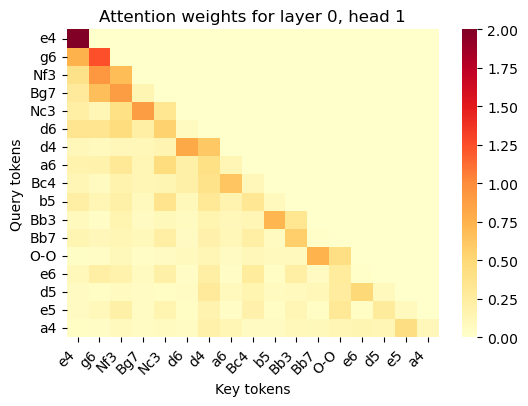

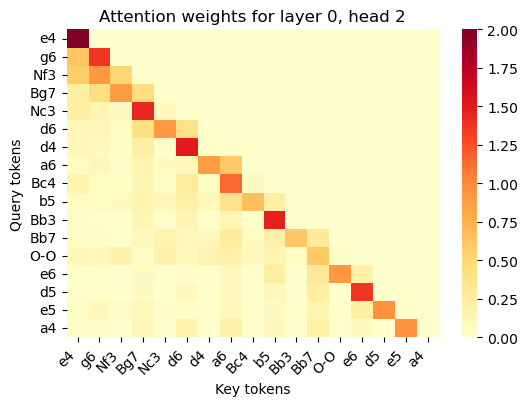

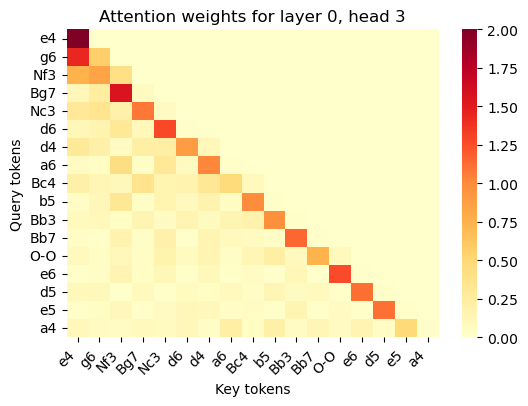

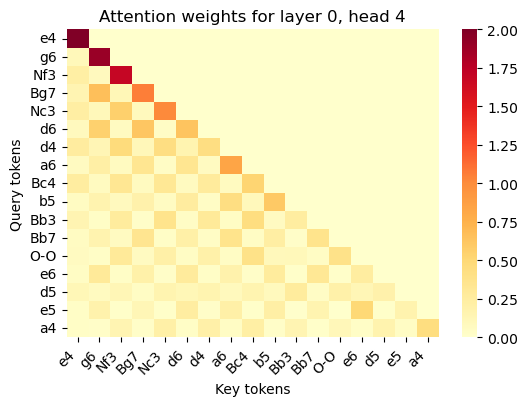

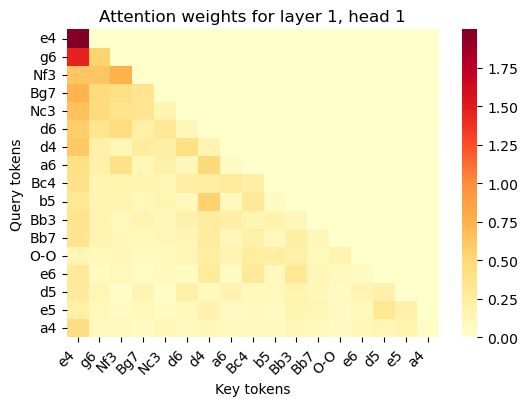

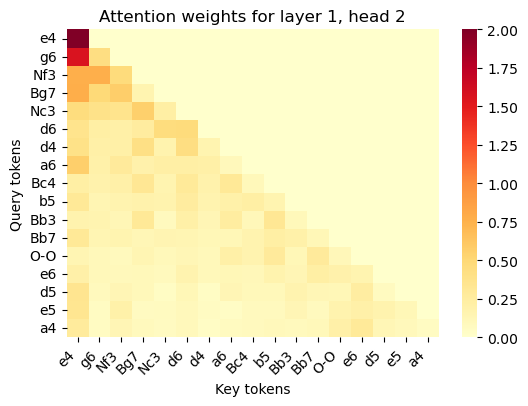

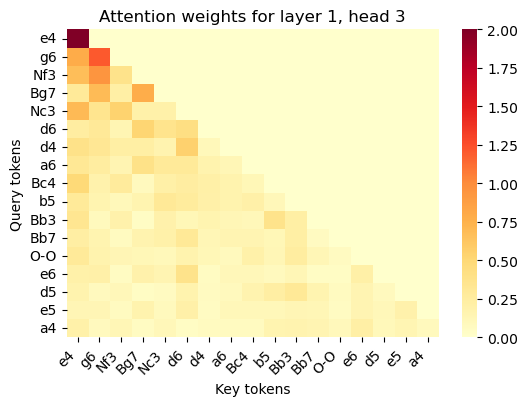

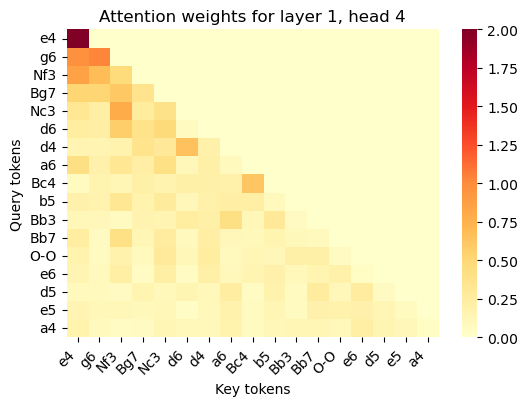

In [80]:
import chess
import sys
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2LMHeadModel, AutoModel
sys.path.append("src")
from data_utils.chess_tokenizer import ChessTokenizer
import chess.pgn as pgn
import io
from datasets import load_dataset
import numpy as np
from scipy.spatial.distance import cosine
import re


# Initialize the Model and the Tokenizer
vocab_path = "vocab.txt"
tokenizer = ChessTokenizer(vocab_path)
model = GPT2LMHeadModel.from_pretrained('shtoshni/gpt2-chess-uci')

num_heads = model.config.num_attention_heads
num_layers = len(model.transformer.h)
print(f"Number of attention layers: {num_layers}")
print(f"Number of heads: {num_heads}")

ds = load_dataset("adamkarvonen/chess_sae_individual_games_filtered")

def get_model_output(input_sequence):
    # Encode the input sequence
    encoded = tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)
    # Convert to tensor and add batch dimension
    inputs = torch.tensor([encoded]).long()
    with torch.no_grad():
        outputs = model(inputs, output_attentions=True, output_hidden_states=True)
    return outputs

def visualize_attention0(input_sequence, layer=-1, head=0):
    outputs = get_model_output(input_sequence)
    attention = outputs.attentions[layer][0, head].cpu().numpy()

    decoded_tokens = [tokenizer.decode_token(t) for t in tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)]
    
    plt.figure(figsize=(6, 4))
    #sns.heatmap(attention, cmap="YlOrRd")   #--> this for token number
    sns.heatmap(attention, cmap="YlOrRd", xticklabels=decoded_tokens, yticklabels=decoded_tokens)
    plt.title(f"Attention weights for layer {layer}, head {head}")
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    plt.show()
    
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def group_tokens(tokens):
    """Group tokens in pairs."""
    grouped_tokens = []
    for i in range(0, len(tokens), 2):
        if i + 1 < len(tokens):
            grouped_tokens.append(f"{tokens[i]}-{tokens[i + 1]}")
        else:
            grouped_tokens.append(tokens[i])  # Handle the case of an odd number of tokens
    return grouped_tokens

def aggregate_attention(attention, group_size):
    """Aggregate attention weights by summing over grouped tokens."""
    num_tokens = attention.shape[0]
    num_groups = (num_tokens + group_size - 1) // group_size  # Calculate number of groups

    aggregated_attention = np.zeros((num_groups, num_groups))

    for i in range(num_groups):
        for j in range(num_groups):
            start_i, end_i = i * group_size, min((i + 1) * group_size, num_tokens)
            start_j, end_j = j * group_size, min((j + 1) * group_size, num_tokens)
            aggregated_attention[i, j] = np.sum(attention[start_i:end_i, start_j:end_j])
    
    return aggregated_attention

from bertviz import head_view, model_view

def visualize_attention(input_sequence, layer=-1, head=0):
    outputs = get_model_output(input_sequence)
    attention = outputs.attentions[layer][0, head].cpu().numpy()

    #head_view(attention, input_sequence, tokenizer)

    decoded_tokens = [tokenizer.decode_token(t) for t in tokenizer.encode(input_sequence, add_special_tokens=False, get_move_end_positions=False)]
    grouped_tokens = group_tokens(decoded_tokens)

    grouped_tokens = re.sub(r'\d+\.', '', str(game.mainline_moves())).split()

    grouped_attention = aggregate_attention(attention, group_size=2)  # Group size of 2 for pairs

    plt.figure(figsize=(6, 4))
    sns.heatmap(grouped_attention, cmap="YlOrRd", xticklabels=grouped_tokens, yticklabels=grouped_tokens)
    plt.title(f"Attention weights for layer {layer}, head {head}")
    plt.xlabel("Key tokens")
    plt.ylabel("Query tokens")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.show()


def probe_attention(move_sequence):
    moves = move_sequence.split()
    if len(moves) < 3:
        print("The move sequence is too short for meaningful analysis.")
        return

    # Visualize attention for the whole sequence
    print("Visualizing attention for the entire move sequence:")
    num_layers = 2
    for i in range(num_layers):
        visualize_attention(move_sequence, i, 1)
        visualize_attention(move_sequence, i, 2)
        visualize_attention(move_sequence, i, 3)
        visualize_attention(move_sequence, i, 4)


# Usage
g = random.randint(0, 90000)
a = ds['train']['text'][g][1:]
b = chop_game_at_random_point(a)

b1 = io.StringIO(b)
game = pgn.read_game(b1)
board = game.board()

move_list = []
for move in game.mainline_moves():
    move_list.append(board.uci(move))
    board.push(move)

b1 = " ".join(move_list)

print("Original game:")
print(b)
print("UCI move sequence:")
print(b1)

# Perform probe_attention
'''
What the heatmaps show:
These heatmaps visualize the attention weights in the transformer model (GPT-2 in this case) for a given input sequence of chess moves.
Axes of the heatmap:
- The y-axis represents the "query" tokens (the current token being processed)
- The x-axis represents the "key" tokens (the tokens being attended to)

Color intensity:
- Brighter colors (more yellow/red) indicate higher attention weights
- Darker colors (more purple/black) indicate lower attention weights

Interpretation:
- Each cell in the heatmap shows how much attention a particular token (y-axis) pays to another token (x-axis) when making its prediction
- The diagonal often shows high attention as tokens frequently attend to themselves

What to look for:
- Patterns of attention (e.g., attention to recent moves, or to specific types of pieces)
- Changes in attention patterns across different layers
- Any unexpected or interesting focus of attention that might give insights into how the model is processing the chess game
'''

'''
ATTENTION:
- 'head' refers to one of the multiple attention mechanisms (attention heads) used in a multi-head self-attention layer of the transformer 
model. Each attention head independently focuses on different parts of the input sequence to capture various relationships and features. 
When visualizing attention, the head parameter allows you to select which of these attention mechanisms to display.7
- 'layers', gpt2_small has 12 attention layers.
    - First Layer: Choose this if you are interested in seeing how the model begins to process the input, 
        especially for analyzing low-level, syntactic patterns and initial token interactions.
    - Last Layer: Choose this if you want to understand the final, high-level interpretations and 
        decisions made by the model, especially for tasks that rely on deeper understanding and context
'''

'''
If the heatmap shows a strong red color in the cell that corresponds to token 7 on the y-axis and token 2 on the x-axis, 
it means that when processing token 7, the model is placing a high attention weight on token 2. 
In other words, the information from token 2 is heavily influencing the processing of token 7.
'''

probe_attention(b1)